# import libraries

In [1]:
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import random

## Value is a data structure that represents a node in a computation graph. it allows:
- storage of values
- operations between values (helps add non linearity and generally with forward prop)
- adding a label to the value (helpful to visualize and track variables)
- it is differentiable
- holds children so we can perform backprop and chain rule (helpful in visualizing draw_dot function that plots the connection between all Value instances)

In [17]:
class Value():
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = _children
        # initialise a private variable backward as a no-op (placeholder) lambda  function that is overwritten by a 
        # specific function operation that requires a unique backprop formula
        self._backward = lambda: None
        self._op = _op
        self.label = label
        # initialise gradient as 0
        self.grad = 0

    # called when an object of the class is called
    # dunder function (they all are typically developer-focused)
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # diff of (a+b) wrt a is 1
        def _backward():
            # gradients have to accumulate within an epoch instead of being overwritten
            # and at the start of a new epoch, we should flush out the grads and start with 0s
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    # this ensures that doing an operation like `1 + value object` works the same as `value object + 1`
    # this goes for all op functions that start with r. r stands for reverse
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + -other
    
    def __rsub__(self, other):
        return self + -other
    
    def __neg__(self):
        return self * -1
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            # diff of (ab) wrt b is a, and wrt a is b
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    # division is just a special case of the pow function
    # implementing it this way helps save compute, ensuring reusability
    def __truediv__(self, other):
        return self * other**(-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int and float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            # diff of (x^n) wrt x is n.x^(n-1)
            self.grad += other * (self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(n*2) - 1) / (math.exp(n*2) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            # diff of tanh(x) wrt x is 1 - tanh^2(x)
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            # diff of exp(x) wrt x is exp(x)
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    # traverse computation graph in reverse order of dependencies (from outputs to inputs)
    # we must process each node only after their dependencies (outputs / nodes on their right) have been processed
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # set the initial gradient seed for backprop
        # gradient of a node with itself is always 1
        self.grad = 1.0
        # traverse toplogical list in reverse order
        for node in reversed(topo):
            node._backward()


In [20]:
a = Value(1.0)
b = Value(4.0)
print(a-b)
print(b-a)
print(a*b)
print(b*a)

Value(data=-3.0)
Value(data=3.0)
Value(data=4.0)
Value(data=4.0)


### func to visualize computation graph with leaf nodes, values, gradients and connections

In [21]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # And connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

### test computation graph with simple neural network like computations

In [5]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1*w1'

x2w2 = x2 * w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

e = (2*n).exp(); e.label = 'e^2x'
o = (e-1) / (e + 1); o.label = 'tanh'


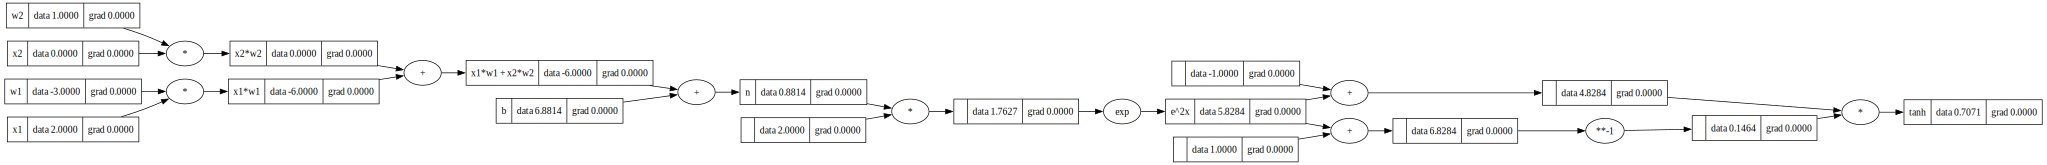

In [6]:
# Draw the computation graph
draw_dot(o)

In [23]:
# perform backprop
o.backward()

### notice how the grad values go from 0 to some other value. this indicates that the .backward func works and populates all value's gradients
### adders simply route the gradient through without a change
### multipliers multiply gradient and other input node for current node

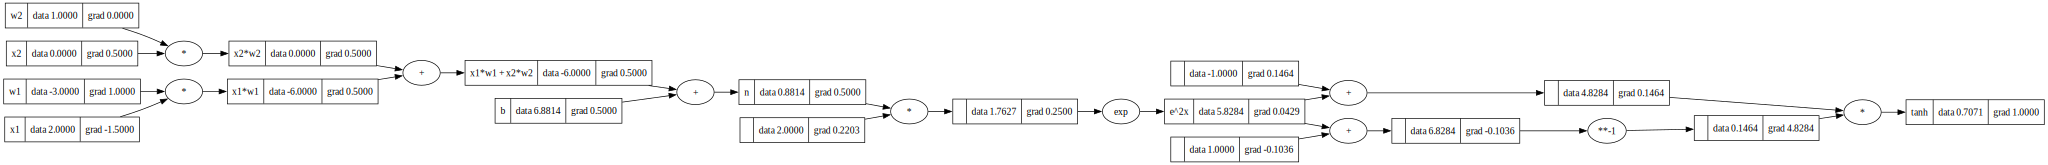

In [8]:
draw_dot(o)

---

## this code defines an MLP (multi layer perceptron) from scratch, using custom classes for neurons and layers

In [26]:
# the neuron class generates uniformly distributed random numbers initializing a bias and weights with a size that matches the incoming values
# it performs the computation $w^Tx + b$ and returns the output value
# it also concatenates w and b params and returns it in parameter func
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # print(self.w, self.b)
        # out = self.w @ x + self.b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

# this layer class creates `nout` number of Neuron objects
class Layer:
    def __init__(self, nin, nout):
        # create nout number of neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

# initializes an MLP object given number of inputs (nin) and a list (nouts) where each elements 
# represents number of neurons in each layer of the network
class MLP:
    def __init__(self, nin, nouts):
        # create layer for each element in nouts with the appropriate number of inputs and outputs for each layer
        sz = [nin] + nouts
        self.mlp = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.mlp:
            x = layer(x)
        
        return x

    def parameters(self):
        return [p for layer in self.mlp for p in layer.parameters()]


In [28]:
# create a synthetic dataset with inputs (xs) and outputs (ys)
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5], 
    [0.5, 1.0, 1.0], 
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [29]:
mlp = MLP(3, [4, 2, 1])

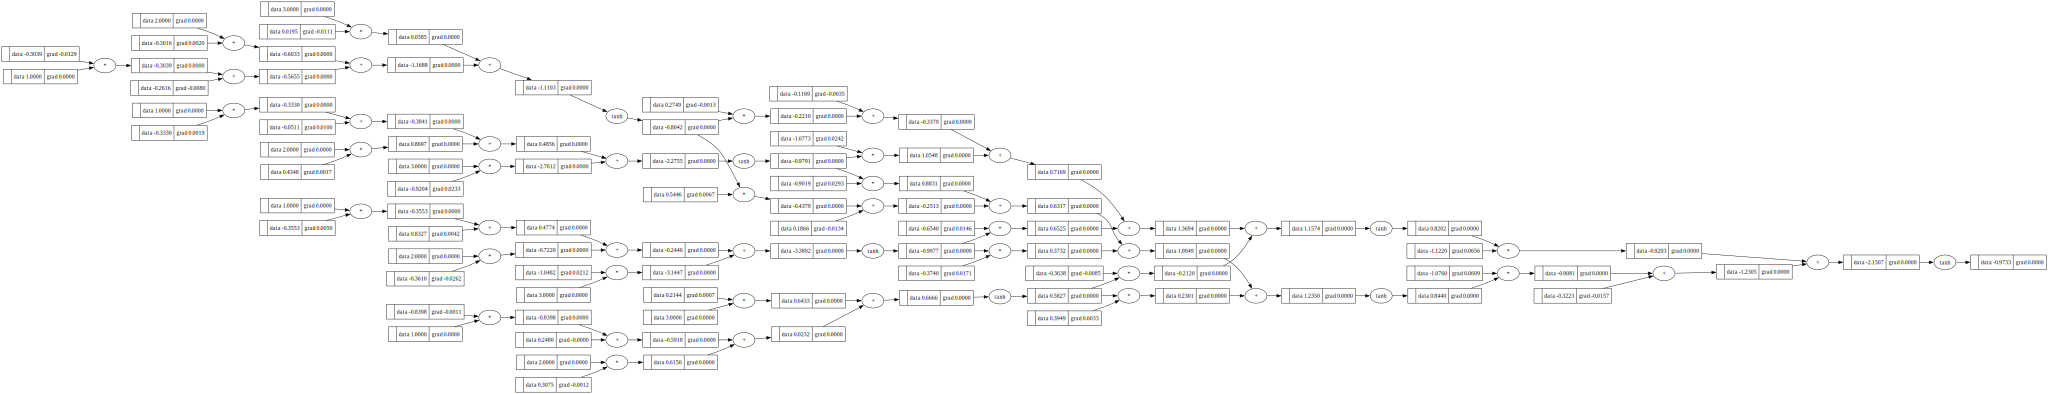

In [37]:
# visualize MLP given a random input vector
draw_dot(mlp([1,2,3]))

In [32]:
mlp.parameters()[0].grad

0

# training loop:
- forward pass where predictions are obtained and loss is calculated
- backward pass where each param's gradient is calculated
- gradient descent update where each param's data is nudged acc to its negative gradient

In [33]:
# collect loss at each epoch in a list so we can plot it later
losses = []

for epoch in range(40):
    # forward pass
    ypred = [mlp(i) for i in xs]
    loss = sum((yp - yt)**2 for yp, yt in zip(ypred, ys))

    # backward pass
    for p in mlp.parameters():
        p.grad = 0.0
    loss.backward()

    # gradient descent update
    for p in mlp.parameters():
        p.data += -0.05 * p.grad
    
    losses.append(loss.data)
    print(f"Epoch {epoch}: Loss: {loss.data}")

Epoch 0: Loss: 3.1388021651101843
Epoch 1: Loss: 1.9026435131553472
Epoch 2: Loss: 1.2855591909354687
Epoch 3: Loss: 0.8232446718963691
Epoch 4: Loss: 0.5384816246919308
Epoch 5: Loss: 0.37505023919417935
Epoch 6: Loss: 0.2782381130954857
Epoch 7: Loss: 0.21712525330402246
Epoch 8: Loss: 0.17609370302631536
Epoch 9: Loss: 0.1470804816011691
Epoch 10: Loss: 0.12568474969168977
Epoch 11: Loss: 0.10936002980814499
Epoch 12: Loss: 0.0965529474155892
Epoch 13: Loss: 0.08627157773937358
Epoch 14: Loss: 0.07785720000244462
Epoch 15: Loss: 0.07085742605596698
Epoch 16: Loss: 0.06495245182482894
Epoch 17: Loss: 0.05991045945266667
Epoch 18: Loss: 0.05555969147083572
Epoch 19: Loss: 0.05177041831787813
Epoch 20: Loss: 0.048442972617360955
Epoch 21: Loss: 0.04549961424442077
Epoch 22: Loss: 0.042878878534741705
Epoch 23: Loss: 0.04053157243070952
Epoch 24: Loss: 0.03841788775757895
Epoch 25: Loss: 0.03650528650625068
Epoch 26: Loss: 0.03476692903421253
Epoch 27: Loss: 0.03318049022046175
Epoch 28

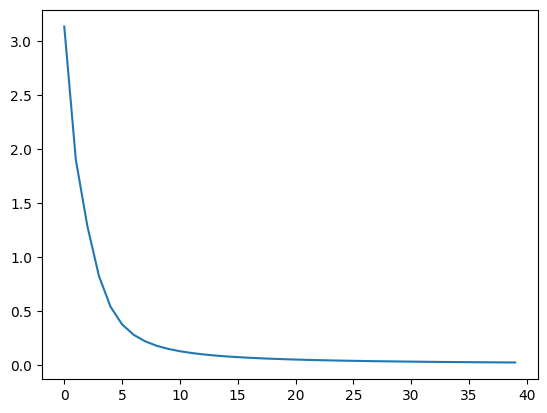

In [34]:
plt.plot(losses)

# observe how the predicted values are very close to true output values

In [35]:
ypred

[Value(data=0.915070966685985),
 Value(data=-0.937920004130897),
 Value(data=-0.9313356602603344),
 Value(data=0.9258075173506526)]